In [41]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import keras
from math import sqrt
import plotly.offline as py
import plotly.graph_objs as go
import keras_tuner as kt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from common.preprocessor import load_data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.regularizers import L1L2
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

In [42]:
data = load_data('data', 'Commodity Prices Monthly.csv')
data.head()

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


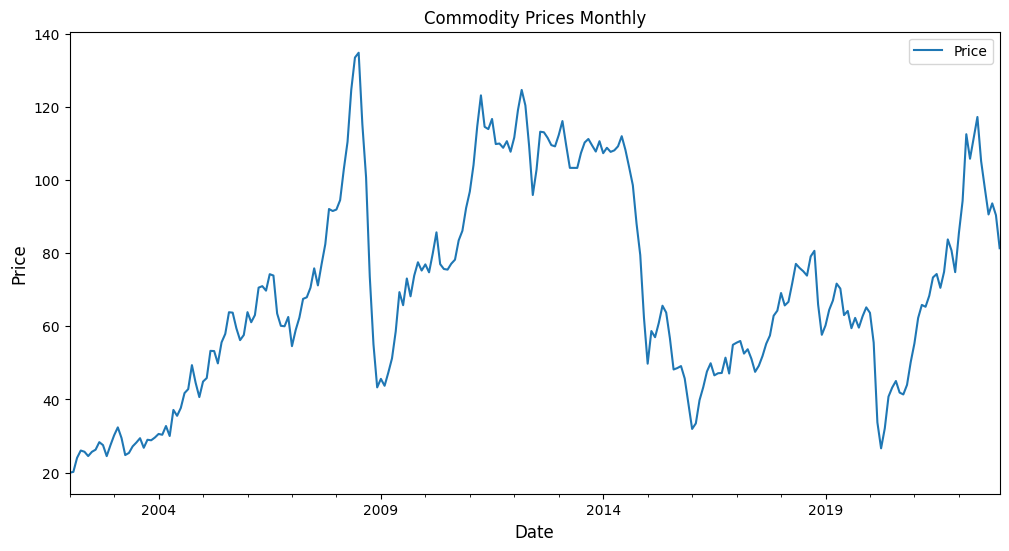

In [43]:
data.plot(y='Price', title='Commodity Prices Monthly', figsize=(12, 6))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [44]:
# set the train and test data with start dates
train_start_date = '2002-01-01'
test_start_date = '2019-01-01'

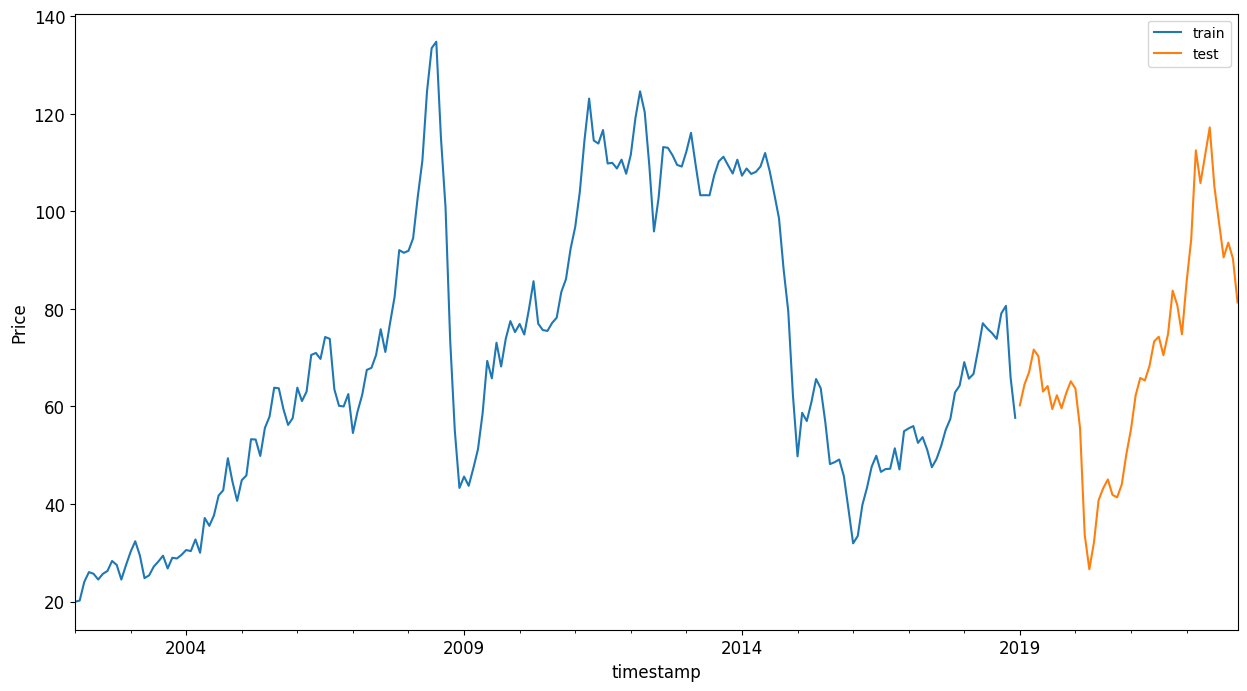

In [45]:
# visualize the train and test data
data[(data.index < test_start_date) & (data.index >= train_start_date)][['Price']].rename(columns={'Price':'train'}) \
    .join(data[test_start_date:][['Price']].rename(columns={'Price':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [46]:
# set the train and test data and print the dimensions of it
train = data.copy()[(data.index >= train_start_date) & (data.index < test_start_date)][['Price']]
test = data.copy()[data.index >= test_start_date][['Price']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (204, 1)
Test data shape:  (48, 1)


In [47]:
train.head(10)

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69
2002-06-01,24.51
2002-07-01,25.67
2002-08-01,26.26
2002-09-01,28.32
2002-10-01,27.51


In [48]:
test.head(10)

,Price
2019-01-01,60.23
2019-02-01,64.50
2019-03-01,67.05
2019-04-01,71.66
2019-05-01,70.30
2019-06-01,63.05
2019-07-01,64.19
2019-08-01,59.47
2019-09-01,62.29
2019-10-01,59.63


In [49]:
# Prepare data for training
scaler = MinMaxScaler()
scaled_train = train.copy()
scaled_test = test.copy()
scaled_train['Price'] = scaler.fit_transform(scaled_train[['Price']])
scaled_test['Price'] = scaler.transform(scaled_test[['Price']])
print(f'Scaled Training Set: {scaled_train.shape}\nScaled Testing Set {scaled_test.shape}')

Scaled Training Set: (204, 1)
Scaled Testing Set (48, 1)


In [50]:
# create a function to prepare the data
def create_dataset(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [51]:
# prepare the data
time_steps = 5
X_train, y_train = create_dataset(scaled_train[['Price']], scaled_train.Price,time_steps)
X_test, y_test = create_dataset(scaled_test[['Price']], scaled_test.Price,time_steps)
print(X_train.shape, y_train.shape)

(199, 5, 1) (199,)


In [52]:
LSTM??

Init signature:
LSTM(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,
    **kwargs,
)
Source:        
@keras_export("keras.layers.LSTM", v1=[])
class LSTM(DropoutRNNCellMixin, RNN, base_layer.BaseRandomLayer):
    """Long Short-Term Memory layer - Hochreiter 1997.

    See [the Keras RNN API guide](https://www.tensorflow.org/guide/keras/rnn)
    for details about the usage of RNN API.

    Based on available runtime hardware and cons

In [53]:
def root_mean_squared_error(y, y_pred):
    return tf.sqrt(mean_squared_error(y, y_pred))

def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= ( X_train.shape[1], X_train.shape[2]), bias_regularizer = L1L2(0.009, 0.004)))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
    model.compile(loss=root_mean_squared_error, optimizer='adam',metrics = ['mse'])
    
    return model

tuner = kt.RandomSearch(model_builder, objective='val_loss', max_trials = 10, executions_per_trial =1,directory = "./silver/")

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                     min_delta=0,    # until it doesn't change (or gets worse)
                                                     patience=5,  # patience > 1 so it continutes if it is not consistently improving
                                                     verbose=0, 
                                                     mode='auto')]

tuner.search(x=X_train, y=y_train, epochs = 100, batch_size =512, validation_data=(X_test, y_test), callbacks=[callbacks],shuffle = True)


Reloading Tuner from ./silver/untitled_project\tuner0.json


In [54]:
tuner.results_summary()


Results summary
Results in ./silver/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 06 summary
Hyperparameters:
input_unit: 96
n_layers: 2
lstm_0_units: 416
Dropout_rate: 0.1
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 256
lstm_3_units: 320
Score: 72.21627044677734

Trial 09 summary
Hyperparameters:
input_unit: 256
n_layers: 1
lstm_0_units: 160
Dropout_rate: 0.45
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 512
lstm_3_units: 416
Score: 72.28218078613281

Trial 08 summary
Hyperparameters:
input_unit: 64
n_layers: 3
lstm_0_units: 160
Dropout_rate: 0.2
dense_activation: relu
lstm_1_units: 512
lstm_2_units: 416
lstm_3_units: 480
Score: 72.44713592529297

Trial 05 summary
Hyperparameters:
input_unit: 288
n_layers: 1
lstm_0_units: 192
Dropout_rate: 0.2
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 64
lstm_3_units: 288
Score: 72.6073989868164

Trial 03 summary
Hyperparameters:
input_unit: 96
n_layers: 4
lstm_0_units: 416
Dr

In [55]:
# LSTM IS BAD AT EXTRAPOLATING (Data outside of training range)
best_model = tuner.get_best_models(num_models=1)[0]

In [56]:
history = best_model.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test, y_test), shuffle=False , verbose=0) # shuffle=False because we want to keep the order of the data


# explain the parameters and the values you used


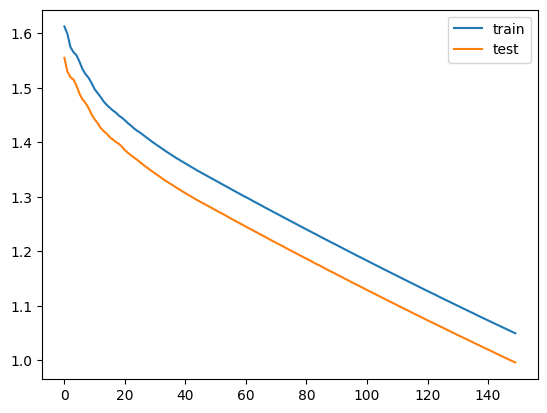

In [57]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [58]:
predictions = best_model.predict(X_test)

2/2 [==============================] - 2s 12ms/step


In [59]:
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

In [60]:
actual = scaler.inverse_transform(y_test.reshape(-1,1))

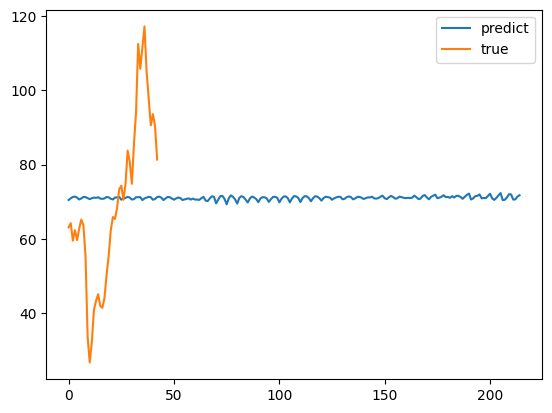

In [61]:
plt.plot(predictions, label='predict')
plt.plot(actual, label='true')
plt.legend()
plt.show()

In [62]:
# evaluate the model
scores = best_model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))

mse: 6.17%


In [63]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape(y,y_pred)

NameError: name 'y' is not defined